## Exercise 5

**Problem 1:** For the static map I have two maps presenting the population distribution of Joensuu city in Eastern Finland. The maps present almost the same thing, but they are made with two different data, which makes them different looking and they have different total population, which shows why also quality of data matters. The first map was made with population grid which was cropped with municipality borders (scale 1:1 000 000) why it is not very accurate as it includes also small parts of other municipalities. The second map was made with postal code area data so it includes only Joensuu's postal code areas and is more precise. I included these both because I started using the postal code area data later in the interactive map and noticed the difference only then. All the data is from Statistics Finland because there wasn't other open data of Joensuu.

In [1]:
# Problem 1: Visualize a static map
# Import the necessary modules
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
%matplotlib inline

# Filepaths
url = 'http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON'
url_vaesto = 'https://geo.stat.fi/geoserver/vaestoruutu/wfs?service=WFS&request=GetFeature&typename=vaestoruutu:vaki2020_5km&outputformat=json' 

# Read the data
municipality = gpd.read_file(url)
population = gpd.read_file(url_vaesto)

# Check the crs of all data
print(municipality.crs)
print(population.crs)

epsg:3067
epsg:3067


1.1. First static map made with population grid and municipality borders

In [3]:
# Select the municipality to examine
joensuu = municipality.loc[municipality['nimi'] == 'Joensuu']

# Select the needed columns
joensuu = joensuu[['kunta', 'nimi', 'geometry']]

# Make the intersection
intersection = gpd.overlay(population, joensuu, how='intersection')

# Check that the crs's are same
print(intersection.crs==joensuu.crs)

print(len(intersection))
intersection.head(3)

True
142


,id,grd_id,id_nro,xkoord,ykoord,kunta_1,vaesto,miehet,naiset,ika_0_14,ika_15_64,ika_65_,kunta_2,nimi,geometry
0,vaki2020_5km.4134,5kmN6905E0695,8363,695000,6905000,848,9,-1,-1,-1,-1,-1,167,Joensuu,"POLYGON ((695778.006 6910000.000, 697737.508 6..."
1,vaki2020_5km.4231,5kmN6910E0690,8497,690000,6910000,848,13,6,7,0,5,8,167,Joensuu,"POLYGON ((693478.747 6915000.000, 695000.000 6..."
2,vaki2020_5km.4232,5kmN6910E0695,8498,695000,6910000,167,21,10,11,2,11,8,167,Joensuu,"POLYGON ((695000.000 6911691.862, 695000.000 6..."


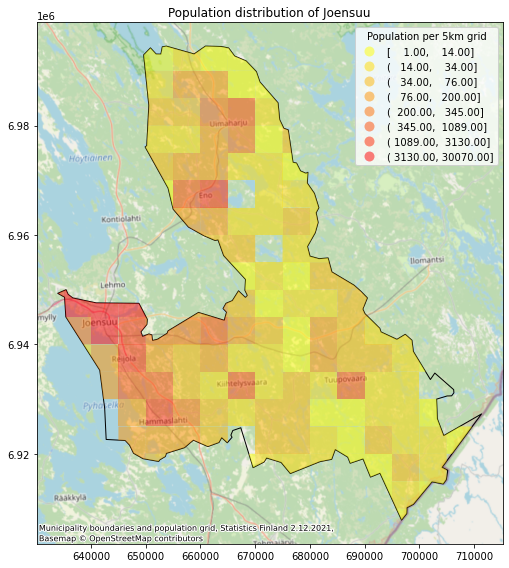

In [6]:
# Create the figure and plot
fig, ax = plt.subplots(figsize=(10,8))
joensuu.plot(ax=ax, color='None', edgecolor='k')
intersection.plot(ax=ax, column='vaesto', scheme='JenksCaspall', k=8, cmap='autumn_r', legend=True, alpha=0.5)

# Add credits
credits = 'Municipality boundaries and population grid, Statistics Finland 2.12.2021,\nBasemap © OpenStreetMap contributors'

# Add basemap
ctx.add_basemap(ax, crs=joensuu.crs, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik, zoom=9)

# Add title
plt.title('Population distribution of Joensuu')

# Set a title for the legend
ax.get_legend().set_title("Population per 5km grid")

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as a png to docs file
outfp = r'docs/Joe_pop_grid.png'
plt.savefig(outfp, dpi=300)

1.2. Static map made with postal code areas of Joensuu

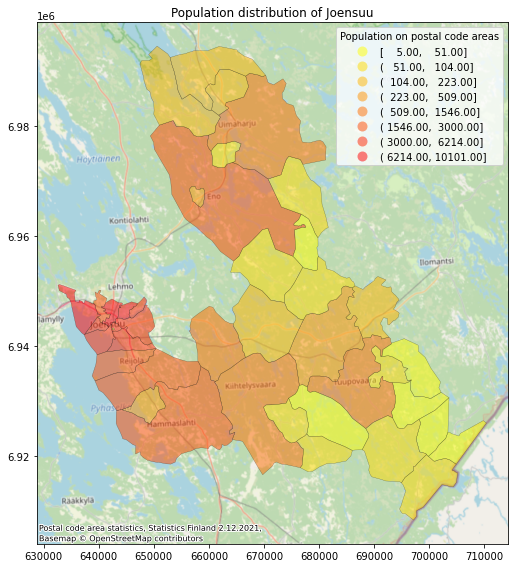

In [7]:
# Read the data
url_paavo = 'https://geo.stat.fi/geoserver/postialue/wfs?request=GetFeature&typename=postialue:pno_tilasto_2021&outputformat=JSON'
paavo = gpd.read_file(url_paavo)

# Crop the postal code data to Joensuu area
joe = paavo.loc[paavo['kunta']=='167']

# Select only the necessary columns (also for the interactive map)
joe = joe[['postinumeroalue', 'nimi', 'euref_x', 'euref_y',  'pinta_ala', 'ra_raky', 'ra_ke', 'he_vakiy', 'geometry']]

# Change the name of the columns
joe = joe.rename(columns={'postinumeroalue':'postalcode', 'nimi':'name','pinta_ala':'area', 'ra_raky':'buildings','ra_ke':'cottages', 'he_vakiy':'population'})

# Create the figure and plot
fig, ax = plt.subplots(figsize=(10,8))
joe.plot(ax=ax, column='population', scheme='JenksCaspall', k=8, cmap='autumn_r',
         edgecolor='k', linewidth=0.3, legend=True, alpha=0.5)

# Add credits
credits = 'Postal code area statistics, Statistics Finland 2.12.2021,\nBasemap © OpenStreetMap contributors'

# Add basemap
ctx.add_basemap(ax, crs=joe.crs, attribution=credits, 
                source=ctx.providers.OpenStreetMap.Mapnik, zoom=9)

# Add title
plt.title('Population distribution of Joensuu')

# Set a title for the legend
ax.get_legend().set_title("Population on postal code areas")

# Remove the empty white-space around the axes
plt.tight_layout()

# Save as png to docs folder
outf = r'docs/Joe_postal.png'
plt.savefig(outf, dpi=300)

In [9]:
# Count the total population of the different data
print('The total population of Joensuu according to the grid data is: {gridpop}.'.format(gridpop=intersection['vaesto'].sum()))
print('The total population of Joensuu according to the postal code area data is: {postpop}.'.format(postpop=joe['population'].sum()))

The total population of Joensuu according to the grid data is: 83225.
The total population of Joensuu according to the postal code area data is: 76315.


**Problem 2:** For The interactive map I used the Statistics Finland postal code area data to visualise and compare amount of buildings, cottages and population in different postal code areas of Joensuu.

In [22]:
import folium
import requests
import geojson

# Change the crs suitable for the basemap
joe3857 = joe.to_crs(epsg=3857)

# Add a geo-id identifier for each row
joe3857['geoid'] = joe3857.index.astype(str)

# Create the folium map
m = folium.Map(location=[62.6448,30.2552], zoom_start=9, crs='EPSG3857')

# Create a chrolopleth map of buildings
folium.Choropleth(geo_data = joe3857, 
                  data = joe3857,
                  name='Buildings in Joensuu',
                  columns=['geoid','buildings'], 
                  key_on='feature.id', 
                  fill_color='RdYlBu_r',
                  fill_opacity=0.5,
                  line_opacity=0.2,
                  legend_name= 'Buildings in Joensuu postal code areas, 2021').add_to(m)

# Create a choropleth map of cottages
folium.Choropleth(geo_data = joe3857,
                  data = joe3857,
                  name='Cottages in Joensuu',
                  columns=['geoid','cottages'],
                  key_on='feature.id',
                  fill_color='RdYlBu_r',
                  fill_opacity=0.5,
                  line_opacity=0.2,
                  legend_name= 'Cottages is Joensuu').add_to(m)

# Convert points to Geojson and create a tooltip map
folium.features.GeoJson(joe3857,  
                        name='Popup statistics',
                        style_function=lambda x: {'color':'gray','fillColor':'transparent','edgecolor':'k','weight':0.5},
                        tooltip=folium.features.GeoJsonTooltip(fields=['buildings','cottages','population','name'],
                                                                aliases = ['Buildings','Cottages','Population','Name'],
                                                                labels=True,
                                                                sticky=False
                                                                            )
                       ).add_to(m)


# Add layer control
folium.LayerControl().add_to(m)

# Show map
m


In [23]:
# Save the map to docs as .html
outfp = r"docs/Joensuu_buildings.html"
m.save(outfp)